## Data Preparation

### Analysis Objectives
- To analyze patterns and trends in citizen feedback across different government services and agencies.
- To assess the overall levels of satisfaction expressed by citizens in response to service resolutions.
- To determine the sentiment polarity of textual feedback to understand the emotional tone behind citizen responses.

### Feature Engineering Objectives
- Extract complaint categories and keywords from descriptions.
- Vectorize resolution text into sentiment, topic clusters or TF-IDF features.
- Encode categorical features such as agency, borough and complaint type.
- Create a binary satisfaction variable for classification modeling.

Unsupervised Clustering on 'Dissatisfaction Reason'
Objective: Extract clusters of dissatisfaction from citizen feedback and optionally enhance with supervised prediction.

Techniques: NLP, Clustering, Pipelines, Object-Oriented Programming

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Importing necessary modelling libraries
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
# Importing NLP libraries 
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Data Understanding

### Data Description

Citizens who submit service requests through the 311 system in New York City are invited to give feedback on how their issue was resolved. Each survey response includes satisfaction ratings and details of the original request. In Kenya, this mirrors platforms like Huduma Kenya and eCitizen, where citizens engage government services. Such feedback helps improve service delivery, accountability and responsiveness across public agencies.

[Data Source](<https://catalog.data.gov/dataset/311-resolution-satisfaction-survey-e4003>)

### Description of Features

- `Unique Key`: A unique identifier for each service request or complaint record.
- `Agency Acronym`: The abbreviated name of the public agency responsible for handling the service request.
- `Agency Name`: The full name of the government agency responsible for the resolution of the reported issue.
- `Complaint Type`: The category or general type of the complaint lodged by the citizen. 
- `Descriptor`: A more specific detail of the complaint. 
- `Borough`: The New York City borough where the complaint was filed or the service was rendered.
- `Resolution Description`: A brief narrative or system-generated explanation of how the agency responded to or resolved the complaint.
- `Survey Year`: The year in which the follow-up survey or feedback was collected from the complainant.
- `Survey Month`: The month in which the survey response was submitted. 
- `Satisfaction Response`: The citizen’s level of satisfaction with how the agency handled the complaint.
- `Dissatisfaction Reason`: An open-ended or predefined text field capturing the citizen's reason for dissatisfaction

, **only present when satisfaction is low** (e.g., "Strongly Disagree"). May contain valuable feedback for clustering or sentiment analysis.

In [2]:
# Loading the data into a dataframe
df = pd.read_csv("311_Resolution_Satisfaction_Survey.csv")
df.head()

,Unique Key,Agency Acronym,Agency Name,Complaint Type,Descriptor,Borough,Resolution Description,Survey Year,Survey Month,Satisfaction Response,Dissatisfaction Reason
0,16657800-00015172,DOB,Department of Buildings,Adult Establishment,Zoning Violation,MANHATTAN,The Department of Buildings investigated this ...,2022,10,Strongly Agree,NaN
1,58524985-00281320,DOB,Department of Buildings,Adult Establishment,Zoning Violation,BROOKLYN,The Department of Buildings investigated this ...,2024,11,Strongly Disagree,The Agency did not correct the issue.
2,75073480-00178242,DFTA,Department for the Aging,Legal Services Provider Complaint,NaN,MANHATTAN,The Department for the Aging contacted you and...,2024,3,Strongly Agree,NaN
3,46435198-00170848,DOB,Department of Buildings,Advertising Sign,Poster,MANHATTAN,The Department of Buildings reviewed this comp...,2024,2,Neutral,NaN
4,40782130-00128055,DOB,Department of Buildings,Advertising Sign,Billboard,MANHATTAN,The Department of Buildings investigated this ...,2023,10,Strongly Disagree,"Status updates were unhelpful, inaccurate, inc..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364689 entries, 0 to 364688
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Unique Key              364689 non-null  object
 1   Agency Acronym          364689 non-null  object
 2   Agency Name             364595 non-null  object
 3   Complaint Type          364689 non-null  object
 4   Descriptor              351714 non-null  object
 5   Borough                 364251 non-null  object
 6   Resolution Description  362933 non-null  object
 7   Survey Year             364689 non-null  int64 
 8   Survey Month            364689 non-null  int64 
 9   Satisfaction Response   364689 non-null  object
 10  Dissatisfaction Reason  224612 non-null  object
dtypes: int64(2), object(9)
memory usage: 30.6+ MB


In [4]:
df.shape

(364689, 11)

In [5]:
df.describe()

,Survey Year,Survey Month
count,364689.000000,364689.000000
mean,2023.725402,6.228951
std,0.921019,3.590012
min,2022.000000,1.000000
25%,2023.000000,3.000000
50%,2024.000000,6.000000
75%,2024.000000,10.000000
max,2025.000000,12.000000


In [6]:
df.describe(include="object")

,Unique Key,Agency Acronym,Agency Name,Complaint Type,Descriptor,Borough,Resolution Description,Satisfaction Response,Dissatisfaction Reason
count,364689,364689,364595,364689,351714,364251,362933,364689,224612
unique,364689,18,19,206,739,5,634,5,8
top,16657800-00015172,NYPD,New York City Police Department,Illegal Parking,Blocked Sidewalk,BROOKLYN,The Department of Housing Preservation and Dev...,Strongly Disagree,The Agency did not correct the issue.
freq,1,165140,165108,81527,34457,129662,47295,195821,110718


In [7]:
df.isna().sum()

Unique Key                     0
Agency Acronym                 0
Agency Name                   94
Complaint Type                 0
Descriptor                 12975
Borough                      438
Resolution Description      1756
Survey Year                    0
Survey Month                   0
Satisfaction Response          0
Dissatisfaction Reason    140077
dtype: int64

### Dealing with missing values

Missing Agency Name values will be reconstructed using their corresponding acronyms (e.g., DOB → Department of Buildings). A dictionary (agency_dict) will be created to map each acronym to its full agency name. This mapping will then be used to fill the missing names. If an acronym does not have a matching name, a default placeholder such as 'Unknown Agency' will be assigned.

Missing values in text-based fields such as Descriptor, Borough, and Resolution Description will be handled using neutral placeholder values like 'Not Provided', 'Unknown Borough', and 'No Description Provided'. This approach maintains data completeness without distorting the original meaning. These placeholders will also enable analysis of whether the absence of specific details correlates with satisfaction levels.

For the Dissatisfaction Reason column, missing values will be conditionally imputed. If a respondent did not select 'Strongly Disagree' in the Satisfaction Response, the missing reason will be filled with 'Not Applicable', as no dissatisfaction was indicated. However, for cases where dissatisfaction is expressed but no reason is provided, the missing value will be retained for closer inspection or careful imputation.


In [8]:
# Filling missing 'Agency Name' using mapping from 'Agency Acronym'
agency_map = df.dropna(subset=['Agency Name']).drop_duplicates('Agency Acronym')[['Agency Acronym', 'Agency Name']]
agency_dict = dict(zip(agency_map['Agency Acronym'], agency_map['Agency Name']))
df['Agency Name'] = df['Agency Acronym'].map(agency_dict).fillna('Unknown Agency')

# Filling descriptor, borough, resolution with placeholders
df['Descriptor'] = df['Descriptor'].fillna('Not Provided')
df['Borough'] = df['Borough'].fillna('Unknown Borough')
df['Resolution Description'] = df['Resolution Description'].fillna('No Description Provided')

# Conditional fill for 'Dissatisfaction Reason'
df['Dissatisfaction Reason'] = df.apply(
    lambda row: 'Not Applicable' if row['Satisfaction Response'] != 'Strongly Disagree' and pd.isnull(row['Dissatisfaction Reason'])
    else row['Dissatisfaction Reason'], axis=1
)

df.isna().sum()

Unique Key                  0
Agency Acronym              0
Agency Name                 0
Complaint Type              0
Descriptor                  0
Borough                     0
Resolution Description      0
Survey Year                 0
Survey Month                0
Satisfaction Response       0
Dissatisfaction Reason    344
dtype: int64

The remaining missing values in Dissatisfaction Reason reflect cases where respondents expressed dissatisfaction but did not specify a reason. These are retained to capture possible gaps in feedback or disengagement, allowing for deeper analysis without losing potentially important patterns.

In [9]:
# Filter them out
missing_reason_with_disagree = df[
    (df['Satisfaction Response'] == 'Strongly Disagree') &
    (df['Dissatisfaction Reason'].isnull())
]

# Look at their distribution by agency or complaint type
print(missing_reason_with_disagree['Agency Name'].value_counts())
print(missing_reason_with_disagree['Complaint Type'].value_counts())

Agency Name
New York City Police Department                       125
Department of Housing Preservation and Development    111
Department of Sanitation                               29
Department of Parks and Recreation                     20
Department of Environmental Protection                 16
Department of Buildings                                11
Department of Finance                                  10
Department of Consumer and Worker Protection            8
Department of Health and Mental Hygiene                 8
Department of Transportation                            6
Name: count, dtype: int64
Complaint Type
Illegal Parking                 59
Heat/Hot Water                  31
Noise - Residential             24
Plumbing                        17
Blocked Driveway                16
                                ..
Encampment                       1
Indoor Sewage                    1
No Building Permit               1
DOF Property - Payment Issue     1
Street Sweeping C

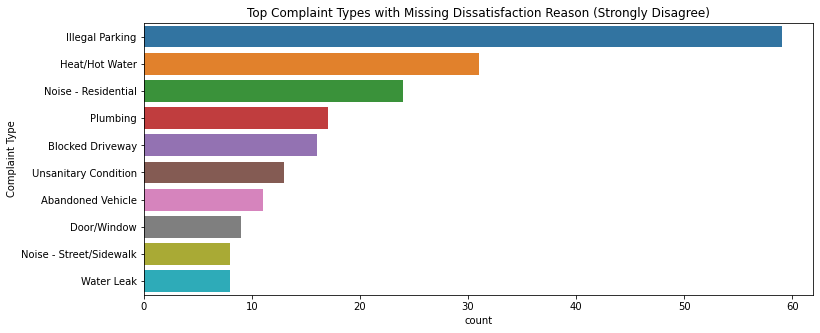

In [10]:
# Countplot of complaint types where reason was missing despite disagreement
plt.figure(figsize=(12,5))
sns.countplot(data=missing_reason_with_disagree, y='Complaint Type', order=missing_reason_with_disagree['Complaint Type'].value_counts().index[:10])
plt.title('Top Complaint Types with Missing Dissatisfaction Reason (Strongly Disagree)')
plt.show(); 

A notable portion of citizens who strongly disagreed with the service experience did not specify a dissatisfaction reason, particularly in complaints involving the New York City Police Department and the Department of Housing Preservation and Development. Common complaint types with missing reasons include Illegal Parking, Heat/Hot Water, and Noise – Residential, suggesting that users may have felt it unnecessary to elaborate or were too frustrated to complete the form. This pattern could point to user fatigue, emotional dissatisfaction, or flaws in form design that fail to prompt for reasons effectively. Before imputing these missing values, it's valuable to recognize them as indicators of possible survey design gaps or user experience issues. To proceed with modeling, one could impute the missing reasons with a neutral placeholder like "Reason Not Provided" while also creating a binary flag to retain their analytical value.


In [12]:
# Imputing the remaining missing values with "Reason not provided"
df['Dissatisfaction Reason'] = df['Dissatisfaction Reason'].fillna('Reason Not Provided')

# Outputting clean dataframe to clean csv file
df.to_csv("cleaned.csv", index=False)